In [1]:
!pip install numpy pandas matplotlib seaborn plotly tensorflow scikit-learn Pillow


In [8]:
import numpy as np
import os ,PIL
from tensorflow import keras
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import shutil
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNet
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [9]:
# Set the path to your dataset directory
dataset_dir = "DataForCnn"

# Set the path to the directory where you want to save the train and test data
train_dir = "v/t"
test_dir = "v/Tt"
valid_dir = test_dir

# Get class labels and number of classes
CLASS_LABELS = os.listdir(dataset_dir)
NUM_CLASSES = len(CLASS_LABELS)

# Define training parameters
EARLY_STOPPING_CRITERIA = 3
SEED = 12
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_SIZE = 256
LR = 0.001
BATCH_SIZE = 10


Class distribution: {'sugarcane': 38, 'rice': 40, 'jute': 39, 'maize': 40, 'wheat': 41}


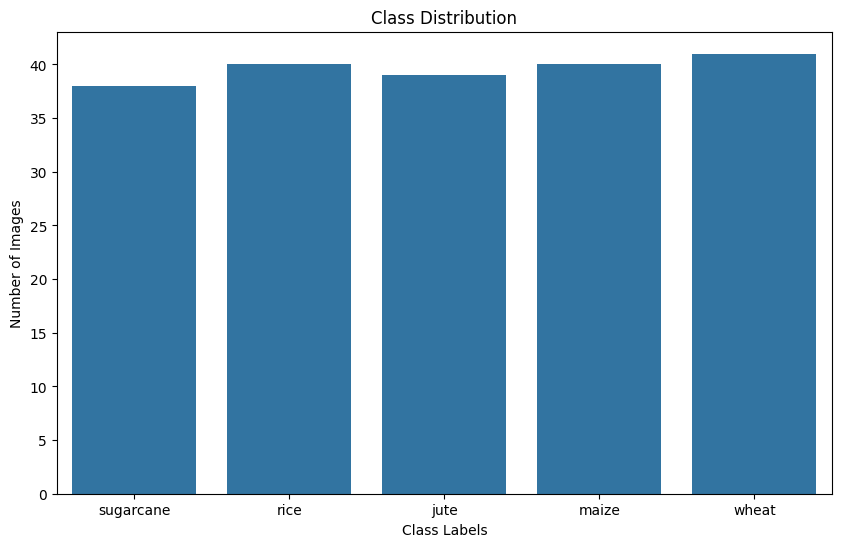

In [10]:
def get_class_distribution(dataset_dir):
    class_counts = {}
    for label in CLASS_LABELS:
        label_dir = os.path.join(dataset_dir, label)
        class_counts[label] = len(os.listdir(label_dir))
    return class_counts

class_distribution = get_class_distribution(dataset_dir)
print("Class distribution:", class_distribution)

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()))
plt.xlabel('Class Labels')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.show()


In [5]:
import hashlib

def calculate_hash(image_path):
    with open(image_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

def find_duplicates(dataset_dir):
    hash_map = {}
    duplicates = []
    for label in CLASS_LABELS:
        label_dir = os.path.join(dataset_dir, label)
        images = os.listdir(label_dir)
        for img in images:
            img_path = os.path.join(label_dir, img)
            img_hash = calculate_hash(img_path)
            if img_hash in hash_map:
                duplicates.append((img_path, hash_map[img_hash]))
            else:
                hash_map[img_hash] = img_path
    return duplicates

duplicates = find_duplicates(dataset_dir)
if duplicates:
    print("Duplicate images found:", duplicates)
else:
    print("No duplicate images found.")


No duplicate images found.


Number of images per class after removing duplicate images:
sugarcane: 38
rice: 40
jute: 39
maize: 40
wheat: 41


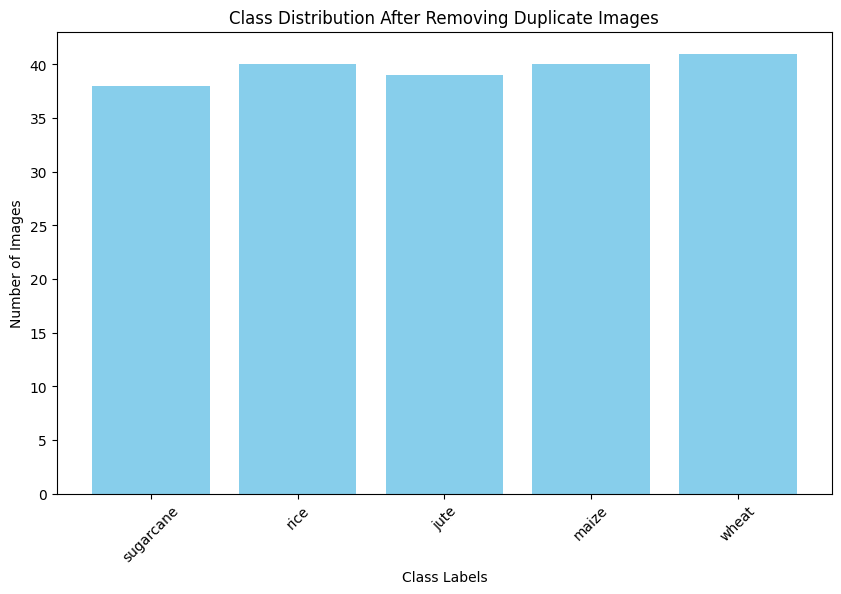

In [7]:
# dataset_dir = "DataForCnn"
# class_labels = os.listdir(dataset_dir)

# # Dictionary to store image hashes
# hash_dict = {}

# for label in CLASS_LABELS:
#     label_dir = os.path.join(dataset_dir, label)
#     images = os.listdir(label_dir)
    
#     for img_name in images:
#         img_path = os.path.join(label_dir, img_name)
#         img_hash = calculate_hash(img_path)
        
#         if img_hash in hash_dict:
#             print(f"Duplicate found: {img_path} and {hash_dict[img_hash]}")
#             os.remove(img_path)
#         else:
#             hash_dict[img_hash] = img_path

# # Recalculate the number of images in each class after removal
# class_counts = {label: len(os.listdir(os.path.join(dataset_dir, label))) for label in class_labels}

# # Print the new counts
# print("Number of images per class after removing duplicate images:")
# for label, count in class_counts.items():
#     print(f"{label}: {count}")

# # Plot the new distribution
# plt.figure(figsize=(10, 6))
# plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
# plt.xlabel('Class Labels')
# plt.ylabel('Number of Images')
# plt.title('Class Distribution After Removing Duplicate Images')
# plt.xticks(rotation=45)
# plt.show()


In [11]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Function to create directory if it does not exist
def create_dir_if_not_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Define directories
dataset_dir = 'DataForCnn'
train_dir = 'v//t'
test_dir = 'v//Tt'
valid_dir = test_dir  # If valid_dir is same as test_dir

# Create train and test directories
create_dir_if_not_exists(train_dir)
create_dir_if_not_exists(test_dir)

# Set the test size (e.g., 20% of the data will be used for testing)
test_size = 0.2
train_size = 0.8

# Get the list of subdirectories (class labels) in the dataset directory
class_labels = os.listdir(dataset_dir)

# Split the dataset into train and test sets for each class
for label in class_labels:
    label_dir = os.path.join(dataset_dir, label)
    train_label_dir = os.path.join(train_dir, label)
    test_label_dir = os.path.join(test_dir, label)
    create_dir_if_not_exists(train_label_dir)
    create_dir_if_not_exists(test_label_dir)

    # Get the list of image files in the current class directory
    images = os.listdir(label_dir)

    # Split the image files into train and test sets
    train_images, test_images = train_test_split(images, test_size=test_size, train_size=train_size)

    # Copy the train images to the train directory
    for train_image in train_images:
        src = os.path.join(label_dir, train_image)
        dst = os.path.join(train_label_dir, train_image)
        if os.path.exists(src):  # Verify if source file exists
            shutil.copy(src, dst)
        else:
            print(f"File {src} does not exist.")

    # Copy the test images to the test directory
    for test_image in test_images:
        src = os.path.join(label_dir, test_image)
        dst = os.path.join(test_label_dir, test_image)
        if os.path.exists(src):  # Verify if source file exists
            shutil.copy(src, dst)
        else:
            print(f"File {src} does not exist.")


In [12]:
# Set the number of classes
num_classes = len(CLASS_LABELS)

# Load the pre-trained MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(256,256, 3))

# Create a Sequential model
model = Sequential()


# Add the pre-trained MobileNet base to the Sequential model
model.add(base_model)
model.add(GlobalAveragePooling2D())

# Add multiple hidden layers
model.add(Dense(128, activation='relu'))  # First hidden layer
model.add(Dense(64, activation='relu'))   # Second hidden layer
model.add(Dense(32, activation='relu'))   # Third hidden layer, you can add more if needed

# Add the output layer
model.add(Dense(num_classes, activation='softmax'))  # Assuming num_classes is defined


for layer in base_model.layers[-20:]:
    layer.trainable = True

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy']) 

# Print the model summary
model.summary()



/tmp/ipykernel_6300/2291940149.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(256,256, 3))
2024-06-18 12:52:28.808490: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-18 12:52:28.809189: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping register

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ ?                      │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for the training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Only rescaling for the validation data
valid_datagen = ImageDataGenerator(rescale=1./255)

# Create the training data generator
train_generator = train_datagen.flow_from_directory(
    'Cnn_crop_Data/train',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

# Create the validation data generator
valid_generator = valid_datagen.flow_from_directory(
    'Cnn_crop_Data/test',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)


2024-06-26 00:22:07.223417: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-26 00:22:07.223848: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-26 00:22:07.226798: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-26 00:22:07.260468: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 00:22:07.961513: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

Found 195 images belonging to 5 classes.
Found 99 images belonging to 5 classes.


In [1]:
# Define the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Number of samples in training and validation sets
train_samples = train_generator.samples
valid_samples = valid_generator.samples

# Train the model
epochs = 30

history = model.fit(
    train_generator,
    steps_per_epoch=train_samples // 32,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=valid_samples // 32,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)



NameError: name 'Sequential' is not defined

In [17]:
# Predict the labels for the validation set
valid_generator.reset()  # Reset the generator to start from the beginning
preds = model.predict(valid_generator, steps=valid_samples // BATCH_SIZE + 1)
predicted_classes = np.argmax(preds, axis=1)
true_classes = valid_generator.classes
class_labels = list(valid_generator.class_indices.keys())

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)

# Calculate precision, recall, and F1 score
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


NameError: name 'true_classes' is not defined